# Ejemplo Series de Tiempo

In [126]:
import pandas as pd
import numpy as np
import pyreadr
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

## Repositorio

- [Ejercicio DeepLearning - ARIMA](https://github.com/JosueSay/DS-DOCS/tree/main/deep_learning)

## Convertir data a csv

In [127]:
DATA_DIR = 'nacXanioMEs.RData'

In [128]:
# Leer el archivo .RData
result = pyreadr.read_r(DATA_DIR)

# Mostrar las claves disponibles
print(result.keys())

# Extraer el DataFrame (si hay uno)
# Si el archivo tiene varias variables, puedes acceder por nombre
df = list(result.values())[0]

# Mostrar las primeras filas
print(df.head())

# Guardar como CSV
df.to_csv('data.csv', index=False)

print("Archivo CSV guardado como 'data.csv'")


odict_keys(['nacXanioMes'])
   Anio Mes  Cantidad
0  2009   1     30715
1  2010   1     30671
2  2011   1     30766
3  2012   1     33127
4  2013   1     33130
Archivo CSV guardado como 'data.csv'


## Parámetro y lectura de datos

In [129]:
tf.random.set_seed(123)

# Leer CSV
df = pd.read_csv("data.csv")

# Renombrar columnas para crear la fecha
df_fecha = df.rename(columns={'Anio': 'year', 'Mes': 'month'})
df_fecha['day'] = 1  # Añadir día fijo

# Crear columna de fecha
df['Fecha'] = pd.to_datetime(df_fecha[['year', 'month', 'day']])

# Reordenar y poner como índice
df.set_index('Fecha', inplace=True)
df.sort_index(inplace=True)

# Dejar solo la columna de interés
df = df[['Cantidad']]

print('\nParsed Data:')
print(df.head())



Parsed Data:
            Cantidad
Fecha               
2009-01-01     30715
2009-02-01     26078
2009-03-01     29319
2009-04-01     27917
2009-05-01     29363


A continuación podemos ver el gráfico de la serie. 

Como se puede ver la serie no es estacionaria en media y la LSTM funciona mejor con series estacionarizadas así que vamos a diferenciarla na vez a ver si es suficiente para estacionarizarla en media

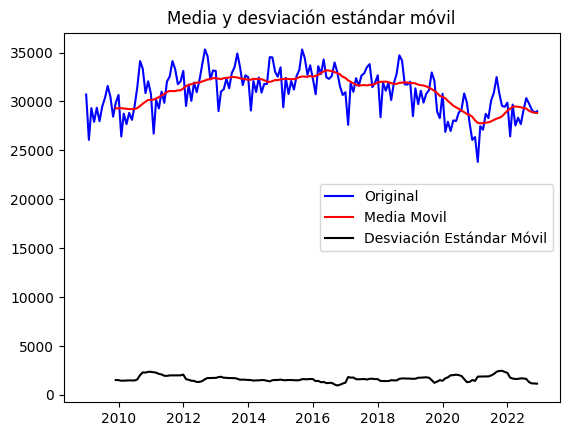

In [130]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = df.rolling(window=12).mean()
deMovil = df.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(df, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

> Muestra estacionalidad. La desviación estándar se mantiene baja queriendo decir que tenemos datos estables.

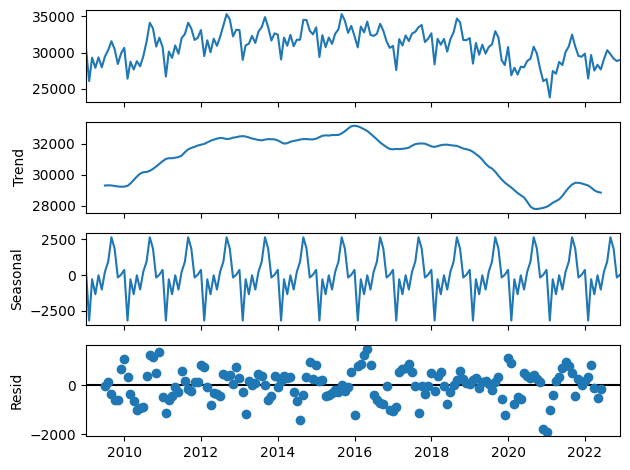

In [131]:
descomposicion = seasonal_decompose(df)
descomposicion.plot();

> Trend: Curva ascendente hasta 2016 y descenso posterior.
>
> Seasonal: Repetición clara mes a mes es decir comportamiento estacional
>
> Resid: Aleatorio, bien centrado → buen modelo aditivo.

En este gráfico se puede observar que hay tendencia por lo que la serie no parece ser estacionaria en media y tampoco en varianza.

In [132]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(df, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -1.276419
p-value                        0.639890
# de retardos usados          12.000000
# de observaciones usadas    155.000000
Critical Value (1%)           -3.473259
Critical Value (5%)           -2.880374
Critical Value (10%)          -2.576812
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias. La serie no es estacionaria en media. Vamos a probar con una diferenciación

In [133]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_air_pas_diff = df.diff()
ts_air_pas_diff.fillna(0,inplace=True)
dfTest = adfuller(ts_air_pas_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -4.032209
p-value                        0.001251
# de retardos usados          11.000000
# de observaciones usadas    156.000000
Critical Value (1%)           -3.472979
Critical Value (5%)           -2.880252
Critical Value (10%)          -2.576747
dtype: float64


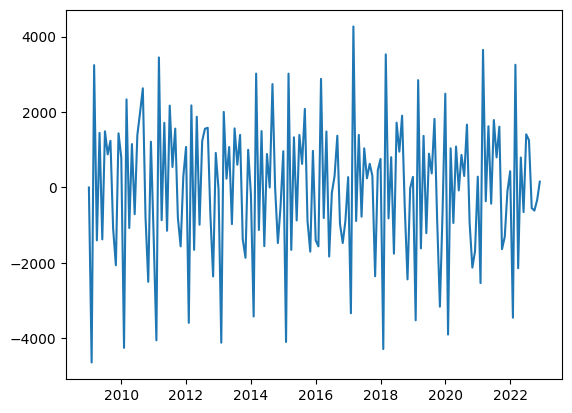

In [134]:
plt.plot(ts_air_pas_diff)

> Acá tenemos variabilidad aleatoria más o menos centrada lol, entonces podemos pasar a LSTM.

Las redes neuronales trabajan mejor con los datos normalizados así que vamos a normalizar la serie:

In [135]:
scaler = StandardScaler()
ts_air_pas_scaled = scaler.fit_transform(ts_air_pas_diff) 
ts_air_pas_scaled[1:7]

array([[-2.54163918],
       [ 1.78593321],
       [-0.7645769 ],
       [ 0.7998971 ],
       [-0.74974516],
       [ 0.8229687 ]])

Vamos a separar la serie en entrenamiento, validación y prueba. En este caso, tendremos 60% para entrenamiento y 20% para validación y prueba respectivamente.

In [136]:
entrenamiento = round(0.6*len(ts_air_pas_scaled))
val_prueba = round(0.2*len(ts_air_pas_scaled))
test = ts_air_pas_scaled[(entrenamiento+val_prueba)-1:]
validation = ts_air_pas_scaled[(entrenamiento):entrenamiento+val_prueba+1]
train = ts_air_pas_scaled[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

34

Para que pueda usarse el argoritmo LSTM es necesario transformar la serie en una supervisada, de manera que las observaciones anteriores sean capaces de estimar la siguiente. En este caso vamos a usar el mes anterior para predecir el siguiente por lo que vamos a transformar el arreglo de numpy en una matriz de dos dimensiones en la que la dimensión 1 sea el instante t-1 y la dimensión 2 sea el instante t

In [137]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)




## Creando el modelo
Para que pueda hacerse el modelo se le tiene que suministrar una matriz de 3 dimensiones siendo estas:
- ***Muestras:*** número de observaciones en cada lote, también conocido como tamaño del lote.
- ***Pasos de tiempo:*** Pasos de tiempo separados para una observación dada. En este ejemplo los pasos de tiempo = 1
- ***Características:*** Para un caso univariante, como en este ejemplo, las características = 1  

Vamos a convertir los conjuntos en matrices de 3 dimensiones:

In [138]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

34

### Creamos el modelo.   
Vamos a utilizar solo una capa lstm  

In [139]:
modelo1 = Sequential()
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada
modelo1.add(LSTM(units=1, input_shape=(1, 1)))
modelo1.add(Dense(1))
modelo1.summary()



d:\UVG GitHub Repositorios\2025\DS-DOCS\deep_learning\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

Compilamos el modelo. Las métricas que nos van a servir para saber como funciona el modelo en términos de la pérdida es el error medio cuadrado. 

In [140]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

Vamos a entrenar el modelo. Para eso configuramos las épocas que es la cantidad de iteraciones. Lo pondremos en 50.

In [141]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1274 - val_loss: 1.1564
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1177 - val_loss: 1.1455
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1093 - val_loss: 1.1360
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1021 - val_loss: 1.1277
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0958 - val_loss: 1.1204
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0903 - val_loss: 1.1141
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0856 - val_loss: 1.1086
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0814 - val_loss: 1.1039
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0778 - val_loss: 1.0997
Epoch 10/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0747 - val_loss: 1.0962
Epoch 11/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0720 - val_loss: 1.0932
Epoch 12/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Como vemos la pérdida empieza a disminuir bastante bien hasta la época 40 que parece estancarse. Hay bastante diferencia entre el modelo de entrenamiento y el de validación.  

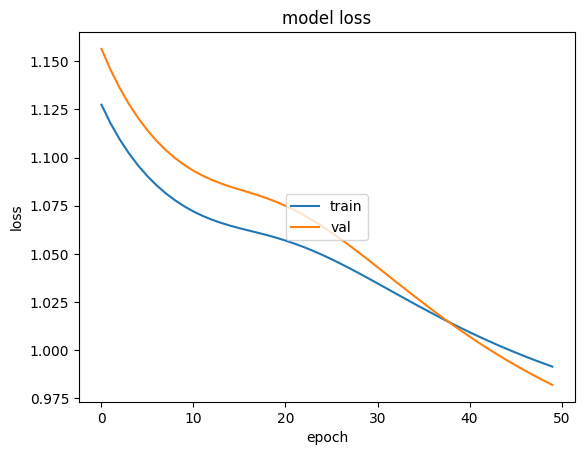

In [142]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

> Tenemos curva de entrenamiento bajo constante, la validación converge también esto quiere decir que no hay sobreajuste claro.

Evaluemos ahora el modelo según la pérdida en cada uno de los conjuntos de datos.

In [143]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9893  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9820
Pérdida en Prueba
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6860


0.6859961152076721

Ahora vamos a predecir con el modelo 1.  

In [144]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = df.values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = df.values , n=entrenamiento+val_prueba)


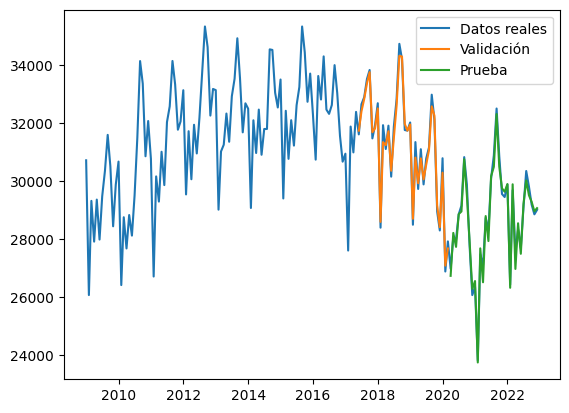

In [145]:
df_val = pd.DataFrame(prediccion_val, index=df[entrenamiento:entrenamiento+val_prueba].index)
df_test = pd.DataFrame(prediccion_test, index=df[entrenamiento+len(df_val):len(df)].index)

plt.plot(df, label="Datos reales")
plt.plot(df_val, label="Validación")
plt.plot(df_test, label="Prueba")

plt.legend()
plt.show()

> Las predicciones siguen aprox la tendencia real de los datos, un poco desfasada y el test muestra más error.

d:\UVG GitHub Repositorios\2025\DS-DOCS\deep_learning\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\UVG GitHub Repositorios\2025\DS-DOCS\deep_learning\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\UVG GitHub Repositorios\2025\DS-DOCS\deep_learning\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


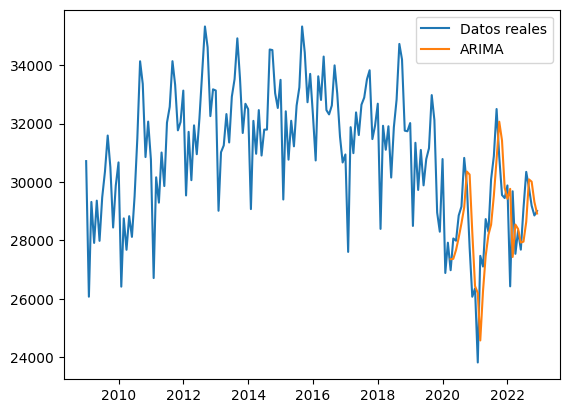

In [146]:
modelo_arima = ARIMA(df, order=(1,1,1))
resultado = modelo_arima.fit()
pred_arima = resultado.predict(start=len(df)-len(df_test), end=len(df)-1, typ='levels')

plt.plot(df, label="Datos reales")
plt.plot(df_test.index, pred_arima, label="ARIMA")
plt.legend()
plt.show()


In [147]:
# Valores reales de prueba
y_true = df[entrenamiento+len(df_val):len(df)].values

# Predicciones
y_pred = df_test.values

# Métricas
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


RMSE: 249.88
MAE: 207.52


Aunque el modelo LSTM es capaz de modelar series temporales complejas, en este caso la serie muestra una estructura clara de estacionalidad y tendencia que ARIMA logra capturar de forma eficiente, con menor error y menor complejidad computacional.